Research question 2: Do decision trees produce more intuitive explanations than LIME?

In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize

blackbox_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

def preprocess_images(img_array):
    img_array = np.array([tf.image.resize(img_to_array(img), (224, 224)) for img in img_array])
    return preprocess_input(img_array)

def black_box_classify(img_array,convert_to_nr=True):
    preprocessed_imgs = preprocess_images(img_array)
    predictions = blackbox_model.predict(preprocessed_imgs)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    if convert_to_nr:
        label_as_nr = label_encoder.transform(labels_as_str)
        return [[l]for l in label_as_nr]
    return [[l]for l in labels_as_str]

def black_box_lime(temp):
    resized_temp = resize(temp, (224, 224), mode='reflect', preserve_range=True).astype(np.uint8)
    resized_temp = np.expand_dims(resized_temp, axis=0)
    predictions = blackbox_model.predict(resized_temp)
    prediction_labels = decode_predictions(predictions, top = 1)
    labels_as_str = [row[0][1] for row in prediction_labels]
    label_as_nr = label_encoder.transform(labels_as_str)
    return [[l]for l in label_as_nr]

In [3]:
import numpy as np
import pickle
import hashlib
import pandas as pd

np.random.seed(42)

base_path = "/Users/karlgustav/Documents/GitHub/study/master-thesis/server/src/research/"
# base_path = "/Users/karl-gustav.kallasmaa/Documents/Projects/master-thesis/server/src/"
all_labels_path = f"{base_path}all_classes.txt"
all_concepts_path = f"{base_path}all_concepts.txt"
masks_path = f"{base_path}data/masks.pkl"
img_path = f"{base_path}data/resized_imgs.pkl"
labels_path = f"{base_path}data/classes.pkl"
ade_path = f"{base_path}data/objectInfo150.csv"

ade_classes = pd.read_csv(ade_path)

images = []
masks = []
unique_labels = []
with open(masks_path, 'rb') as f:
    masks = pickle.load(f)
with open(img_path, 'rb') as f:
    images = pickle.load(f)
with open(all_labels_path) as f:
    lines = f.read().splitlines()
    lines = [l.replace(' ', '_') for l in lines]
    unique_labels = np.array(list(set(lines)))

labels = black_box_classify(images,False)
labels = [l[0] for l in labels]

all_concept_values = ade_classes['Name'].tolist()
UNIQUE_CONCEPT_VALUES = sorted(list(set(all_concept_values)))
NR_OF_UNIQUE_CONCEPTS = len(UNIQUE_CONCEPT_VALUES)


image_hex_index_map = {hashlib.sha1(np.array(img).view(np.uint8)).hexdigest(): i for i,img in enumerate(images)}

index_img_map = {i:img for i,img in enumerate(images)}
index_label_map = {i:label for i,label in enumerate(labels)}
index_mask_map = {i:mask for i,mask in enumerate(masks)}
index_ade_map = {i:ade for i,ade in enumerate(ade_classes)}

test_image_count = 10

random_indexes = np.random.choice(list(index_img_map.keys()), test_image_count, replace=False)

random_images = [index_img_map[index] for index in random_indexes]
random_labels = np.array([index_label_map[index] for index in random_indexes])
random_masks = [index_mask_map[index] for index in random_indexes]

print("Total number of images "+str(len(images)))
print("Number of images used "+str(len(random_images)))

50/50 [==============================] - 32s 623ms/step
Total number of images 1592
Number of images used 10


In [4]:
from typing import List
from sklearn import preprocessing

def encode_categorical_values(values: List[str]):
    unique_values = sorted(list(set(values)))
    le = preprocessing.LabelEncoder()
    le.fit(unique_values)
    return le

label_encoder = encode_categorical_values(unique_labels)

Explain using lime

In [5]:
from lime import lime_image

def explain_with_lime(images):
    explainer = lime_image.LimeImageExplainer()
    explanations = []
    for i,image in enumerate(images):
        lime_img_exp = explainer.explain_instance(np.array(image),
                                                 classifier_fn=black_box_classify,
                                                 top_labels=3,
                                                 batch_size=100,
                                                 num_samples=150,
                                                 hide_color=None)
        temp, mask = lime_img_exp.get_image_and_mask(lime_img_exp.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        prediction_on_temp = black_box_lime(temp)

        result = {
            "image": image,
            "explanation": temp,
            "mask": mask,
            "prediction": prediction_on_temp[0][0],
            "label": random_labels[i]
        }
        explanations.append(result)
    return explanations

/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Explain using the framework

In [6]:
from operator import itemgetter
from typing import Dict, List

def get_segments(img, mask, threshold=0.05):
    segs = np.unique(mask)
    segments = []
    total = mask.shape[0] * mask.shape[1]
    segments_classes = []
    
    for seg in segs:
        idxs = mask == seg
        sz = np.sum(idxs)
        
        if sz < threshold * total:
            continue
        
        coords = np.argwhere(idxs)
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)
        
        segment_img = img[x_min:x_max+1, y_min:y_max+1, :]
        
        segments.append(segment_img)
        segments_classes.append(ade_classes['Name'].loc[ade_classes['Idx'] == seg].iloc[0])
    
    return segments, segments_classes

def sort_dictionary(source: Dict[any, any], by_value=True, reverse=True) -> List[any]:
    if by_value:
        return sorted(source.items(), key=itemgetter(1), reverse=reverse)
    return sorted(source.items(), key=itemgetter(0), reverse=reverse)

In [7]:
from typing import Dict, List
from mpire import WorkerPool
from functools import reduce

class MostPopularConcepts:
    BATCH_SIZE = 10
    MAX_WORKER_COUNT = 8

    def __init__(self,l_labels,i_images,m_maks):
        all_labels = np.array(l_labels)
        chunk_size = max(1, int(all_labels.size / self.BATCH_SIZE))
        self.labels_in_chunks = np.array_split(all_labels, chunk_size)
        self.nr_of_jobs = min(self.MAX_WORKER_COUNT, len(self.labels_in_chunks))

        self.label_images_map = {}
        self.label_masks_map = {}

        self.image_most_popular_concepts = self.static_most_popular_concepts(l_labels,i_images,m_maks)

    def static_most_popular_concepts(self,l_labels,i_images,m_maks) -> Dict[str, List[any]]:
        for label, image, mask in zip(l_labels,i_images,m_maks):
            current_images = self.label_images_map.get(label, [])
            current_maks = self.label_masks_map.get(label, [])

            current_images.append(image)
            current_maks.append(mask)

            self.label_images_map[label] = current_images
            self.label_masks_map[label] = current_maks

        with WorkerPool(n_jobs=self.nr_of_jobs) as pool:
            return reduce(lambda a, b: {**a, **b},
                          pool.map(self.__extract_most_popular_concepts, self.labels_in_chunks))

    def __extract_most_popular_concepts(self, l_labels: List[str]) -> Dict[str, List[any]]:
        partial_results = {}
        for label in  l_labels:
            i_images = self.label_images_map[label]
            m_masks = self.label_masks_map[label]
            nr_of_images = len(i_images)
            partial_results[label] = self.most_popular_concepts(images,m_masks, nr_of_images)
        return partial_results

    @staticmethod
    def most_popular_concepts(i_images, m_masks, k) -> List[str]:
        segment_count = {}
        for pic, mask in zip(i_images, m_masks):
            _, seg_class = get_segments(np.array(pic), mask, threshold=0.005)
            for s in seg_class:
                segment_count[s] = segment_count.get(s, 0) + 1
        segment_count = sort_dictionary(segment_count)
        return [s for s, _ in segment_count[:k]]

In [8]:
from typing import List
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


def get_segment_relative_size(segment: np.array, picture: np.array) -> float:
    segment_area = float(segment.shape[0] * segment.shape[1])
    picture_area = float(picture.shape[0] * picture.shape[1])
    return round(segment_area / picture_area, 2)


def get_training_row(top_concepts_for_label: List[str], pic, mask) -> np.array:
    row = np.zeros(NR_OF_UNIQUE_CONCEPTS)
    pic_as_array = np.array(pic)
    segss, seg_class = get_segments(pic_as_array, mask, threshold=0.005)
    for index,concept in enumerate(UNIQUE_CONCEPT_VALUES):
        if concept in top_concepts_for_label and concept in seg_class:
            segment = segss[seg_class.index(concept)]
            row[index] = get_segment_relative_size(segment, pic_as_array)            
    return row

def train_decision_tree(x, y) -> DecisionTreeClassifier:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    return clf

def train_concept_explainer(all_labels,all_images,all_masks):
    X, y = [], []
    for label, pic, mask in zip(all_labels,all_images, all_masks):
        most_popular_concepts_for_label = MOST_POPULAR_CONCEPTS[label]
        row = get_training_row(most_popular_concepts_for_label, pic, mask)
        label_as_nr = label_encoder.transform([label])
        X.append(row)
        y.append(label_as_nr[0])
    return train_decision_tree(X,np.array(y))

In [9]:
from typing import Optional

class HumanReadableExplanation:
    def __init__(self,
                 true_label: Optional[str],
                 predicted_label: str,
                 feature_importance: List[dict[str, float]]):
        self.true_label = true_label
        self.predicted_label = predicted_label
        self.feature_importance = feature_importance

    def to_db_format(self) -> Dict[str, any]:
        payload = {
            "trueLabel": self.true_label,
            "predictedLabel": self.predicted_label,
            "featureImportance": self.feature_importance,
        }
        to_be_deleted = [key for key, value in payload.items() if value is None]
        for key in to_be_deleted:
            del payload[key]
        return payload


In [10]:
class HumanReadableExplanationService:
    def __init__(self,
                 feature_encoder: preprocessing.LabelEncoder,
                 estimator: DecisionTreeClassifier):
        self.feature_encoder = feature_encoder
        self.estimator = estimator

    def  human_readable_explanation(self, x_test, y_test, y_true) -> Dict[str, any]:
        features = self.estimator.tree_.feature
        node_indicator = self.estimator.decision_path(x_test)
        leave_id = self.estimator.apply(x_test)

        sample_id = 0
        node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                            node_indicator.indptr[sample_id + 1]]

        features_present_in_explanation = []

        for node_id in node_index:
            if leave_id[sample_id] != node_id:
                readable_feature = self.feature_encoder.inverse_transform([features[node_id]])[0]
                features_present_in_explanation.append(readable_feature)

        true_label_message = f"True label for this image: {label_encoder.inverse_transform(y_true)[0]}"
        predicted_label_message = f"Predicted label for this image: {label_encoder.inverse_transform([y_test])[0]}"

        human_readable_explain = HumanReadableExplanation(
            true_label=true_label_message,
            predicted_label=predicted_label_message,
            feature_importance=self.__feature_importance(features_present_in_explanation),
        )
        return human_readable_explain.to_db_format()

    def __feature_importance(self, features_in_local_explanation: List[str]) -> List[Dict[str, float]]:
        results = {feature: {"featureName": feature, "global": importance} for feature, importance in zip(self.feature_encoder.classes_, self.estimator.feature_importances_)}

        feature_local_score = {feature: results[feature]["global"] for feature in features_in_local_explanation}
        total_local_score = sum(feature_local_score.values())
        feature_local_score = {k: v / total_local_score for k, v in feature_local_score.items()}

        for feature_name in results:
            local_score = feature_local_score.get(feature_name, 0)
            global_score = results[feature_name]["global"]

            local_score = round(100*local_score, 2)
            global_score = round(100*global_score, 2)

            results[feature_name]["local"] = local_score
            results[feature_name]["global"] = global_score

        return sorted(list(results.values()), key=lambda x: x["local"], reverse=True)

In [19]:
def encode_categorical_features():
    with open(all_concepts_path) as f:
        all_concepts = f.read().splitlines()
    return encode_categorical_values(all_concepts)

def explain_with_concepts(l_labels,i_images,m_masks,model):
    
    feature_encoder = encode_categorical_features()

    hre = HumanReadableExplanationService(feature_encoder=feature_encoder,
                                          estimator=model)

    explanations = []
    for label,img,mask in zip(l_labels,i_images,m_masks):        
        most_popular_concepts_for_label = MOST_POPULAR_CONCEPTS[label]
        row = get_training_row(most_popular_concepts_for_label, img, mask)

        prediction_as_nr = model.predict([row])
        correct_label_as_nr = label_encoder.transform([label])

        explanation = hre.human_readable_explanation(x_test=[row],
                                                 y_test=prediction_as_nr,
                                                 y_true=correct_label_as_nr) # TODO: this is wrong
        explanations.append(explanation)
    return explanations

In [12]:
MOST_POPULAR_CONCEPTS = MostPopularConcepts(labels,images,masks).image_most_popular_concepts

Explain each image

In [13]:
lime_explanations = explain_with_lime(random_images)

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 92/150 [00:01<00:00, 82.09it/s]

4/4 [==============================] - 2s 461ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:04<00:00, 36.97it/s]


1/1 [==============================] - 0s 470ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 88/150 [00:00<00:00, 134.67it/s]

4/4 [==============================] - 2s 474ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 45.80it/s]


1/1 [==============================] - 0s 97ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 91/150 [00:00<00:00, 126.32it/s]

4/4 [==============================] - 2s 459ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 44.82it/s]


1/1 [==============================] - 0s 216ms/step


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 99/150 [00:00<00:00, 160.67it/s]

4/4 [==============================] - 2s 457ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 49.03it/s]


1/1 [==============================] - 0s 85ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 90/150 [00:00<00:00, 140.42it/s]

4/4 [==============================] - 2s 453ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 47.10it/s]


1/1 [==============================] - 0s 74ms/step


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 89/150 [00:00<00:00, 171.45it/s]

4/4 [==============================] - 2s 447ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 50.78it/s]


1/1 [==============================] - 0s 71ms/step


 57%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 86/150 [00:00<00:00, 135.86it/s]

4/4 [==============================] - 2s 452ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 47.10it/s]


1/1 [==============================] - 0s 86ms/step


 58%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 87/150 [00:00<00:00, 163.78it/s]

4/4 [==============================] - 2s 456ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 49.73it/s]


1/1 [==============================] - 0s 77ms/step


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 91/150 [00:00<00:00, 122.48it/s]

4/4 [==============================] - 2s 457ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 44.67it/s]


1/1 [==============================] - 0s 125ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 88/150 [00:00<00:00, 135.86it/s]

4/4 [==============================] - 2s 454ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 46.98it/s]


1/1 [==============================] - 0s 99ms/step


In [14]:
concept_model = train_concept_explainer(labels,images,masks)

In [20]:
concept_explanations = explain_with_concepts(random_labels,random_images,random_masks,concept_model)

/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/homebrew/Cellar/jupyterlab/4.0.3/libexec/lib/python3.11/site-packages/sklearn/preprocessing/

In [24]:
def visualize_lime(explanation):
    label_name = label_encoder.inverse_transform([explanation['prediction']])[0]
    print("Prediction: "+label_name)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))

    # Original image
    # Temp image
    temp = explanation['explanation'].astype(float)
    temp /= np.max(temp)
    ax1.imshow(temp)
    ax1.set_title('LIME image')


    # Mask on image
    temp = explanation['explanation'].astype(float)
    temp /= np.max(temp)
    ax2.imshow(mark_boundaries(temp, explanation['mask']))
    ax2.set_title('LIME image with masks')

    # Image with mask applied
    img_arr = np.array(explanation['image'])
    img = img_arr.astype(float)
    img /= np.max(img)
    ax3.imshow(mark_boundaries(img, explanation['mask']))
    ax3.set_title('Mask boundaries')

    plt.show()
    
def visulize_concept_exp(explanation):
    print(explanation["trueLabel"])
    print(explanation["predictedLabel"])
    
    sorted_data = sorted(explanation['featureImportance'], key=lambda x: x['local'], reverse=True)
    top_ten_concepts = sorted_data[:10]

    
    feature_names = [item['featureName'] for item in top_ten_concepts]
    # global_importance = [item['global'] for item in top_ten_concepts]
    local_importance = [item['local'] for item in top_ten_concepts]

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.barh(feature_names,local_importance , color='blue', label='Gini Importance')

    # ax.plot( global_importance, feature_names, 'o', color='red', markersize=8, label='Global Importance')

    ax.set_xlabel('Importance')
    ax.set_ylabel('Concept Name')
    ax.set_title('Concept Importance')

    ax.legend()

    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()    

In [25]:
import PIL
import PIL.IcoImagePlugin
import PIL.Image
import uuid
import os
from PIL import Image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def temp_img(index):
    image_pil = random_images[index]
    temp_image_path = str(uuid.uuid4())+".jpg"
    image_pil.save(temp_image_path)
    return temp_image_path

def vizualise_img(path):
    open_image = Image.open(path)
    plt.imshow(open_image)
    plt.axis('off')
    plt.show()
    os.remove(path)

def vizualise_explanation(index):
    correct_label = random_labels[index]
    
    temp_image_path = temp_img(index)
    vizualise_img(temp_image_path)
    
    print("Correct label: "+correct_label)
    
    lime_explanation = lime_explanations[index]
    print("")
    print("LIME explanation")
    print("")
    visualize_lime(lime_explanation)
    print("")
    print("Concept explanation")
    print("")
    concept_explanation = concept_explanations[index]
    visulize_concept_exp(concept_explanation)
    

Image 1


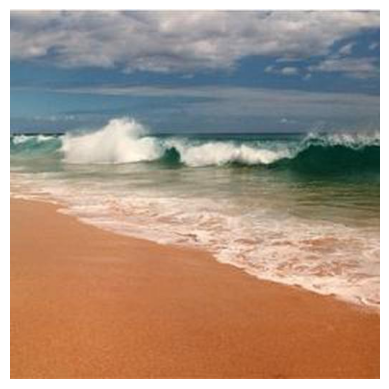

Correct label: seashore

LIME explanation

Prediction: seashore


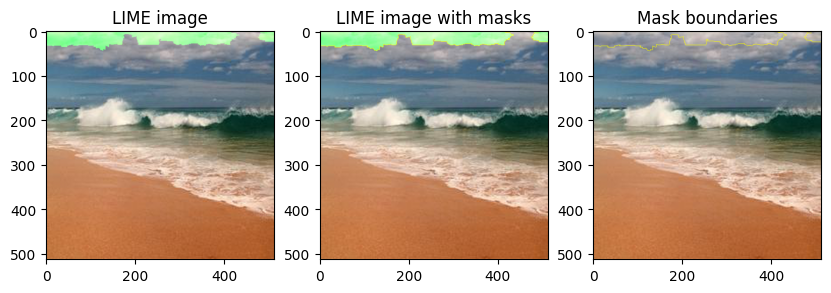


Concept explanation

True label for this image: seashore
Predicted label for this image: seashore


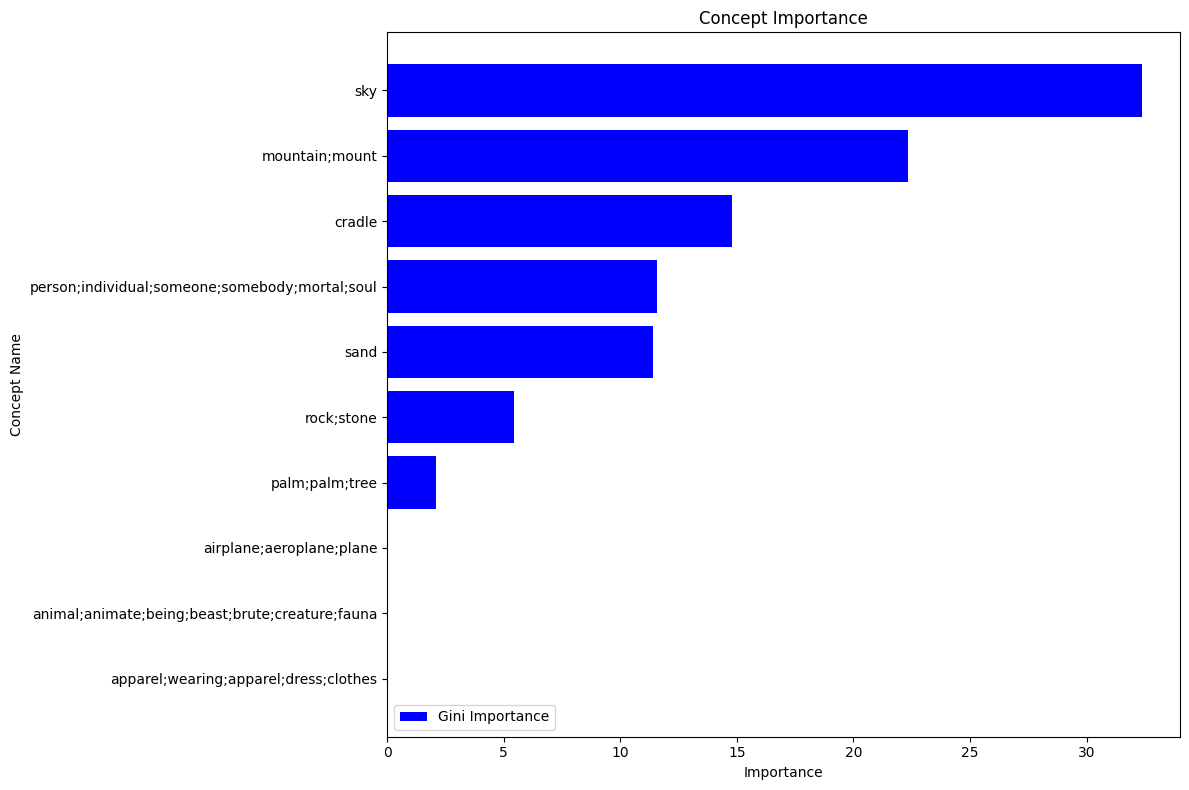

Image 2


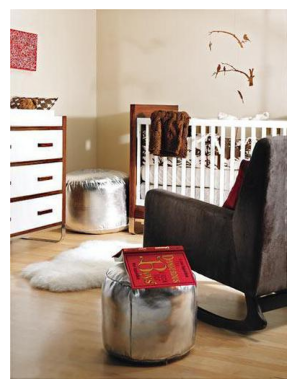

Correct label: studio_couch

LIME explanation

Prediction: lighter


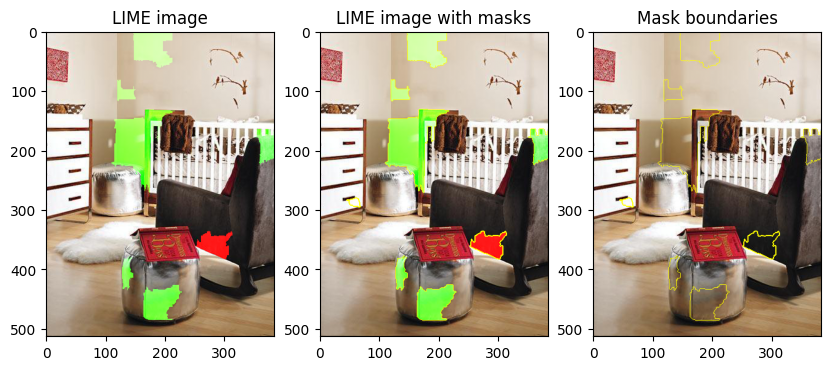


Concept explanation

True label for this image: studio_couch
Predicted label for this image: studio_couch


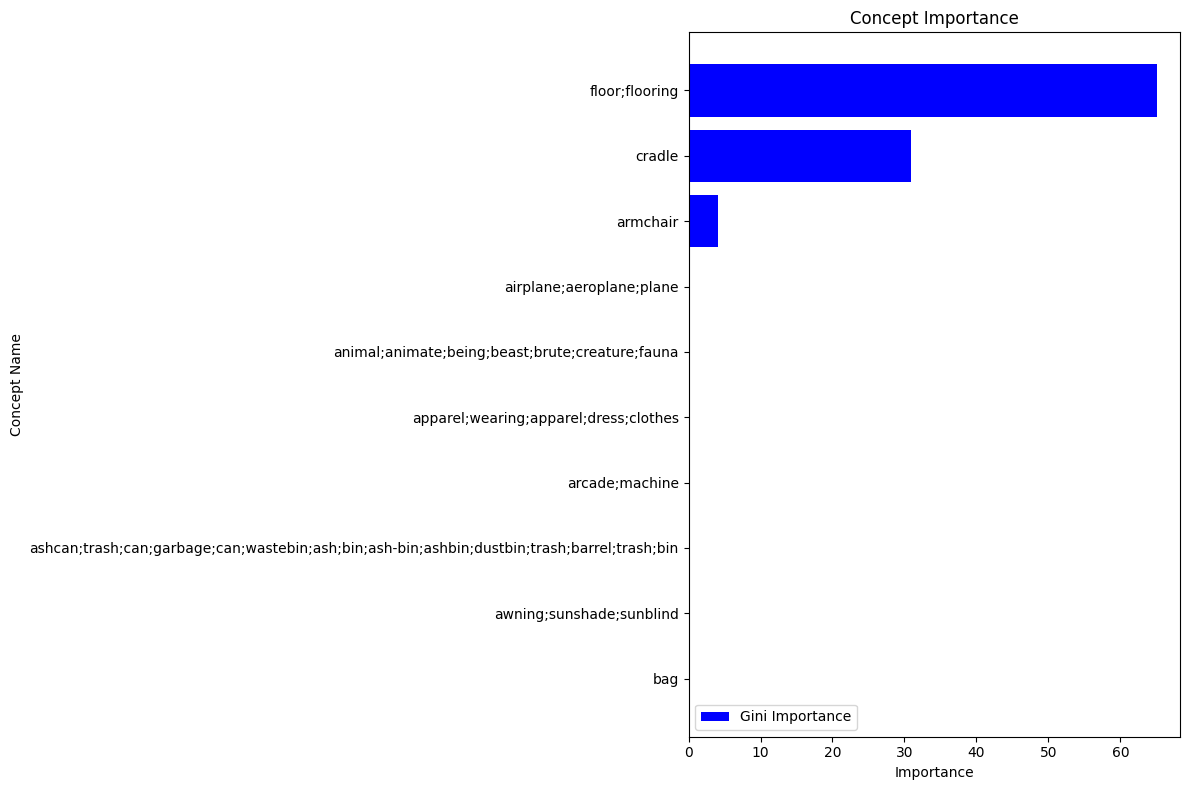

Image 3


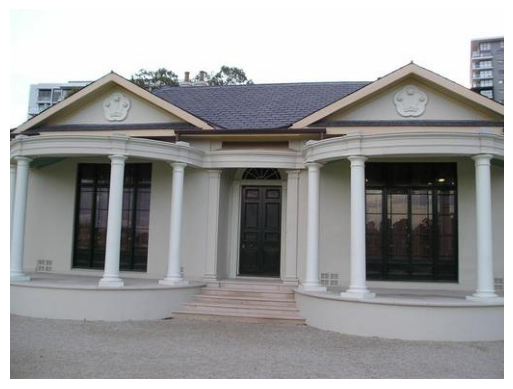

Correct label: tile_roof

LIME explanation

Prediction: picket_fence


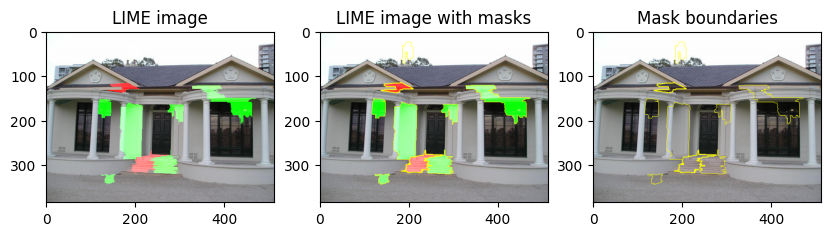


Concept explanation

True label for this image: tile_roof
Predicted label for this image: tile_roof


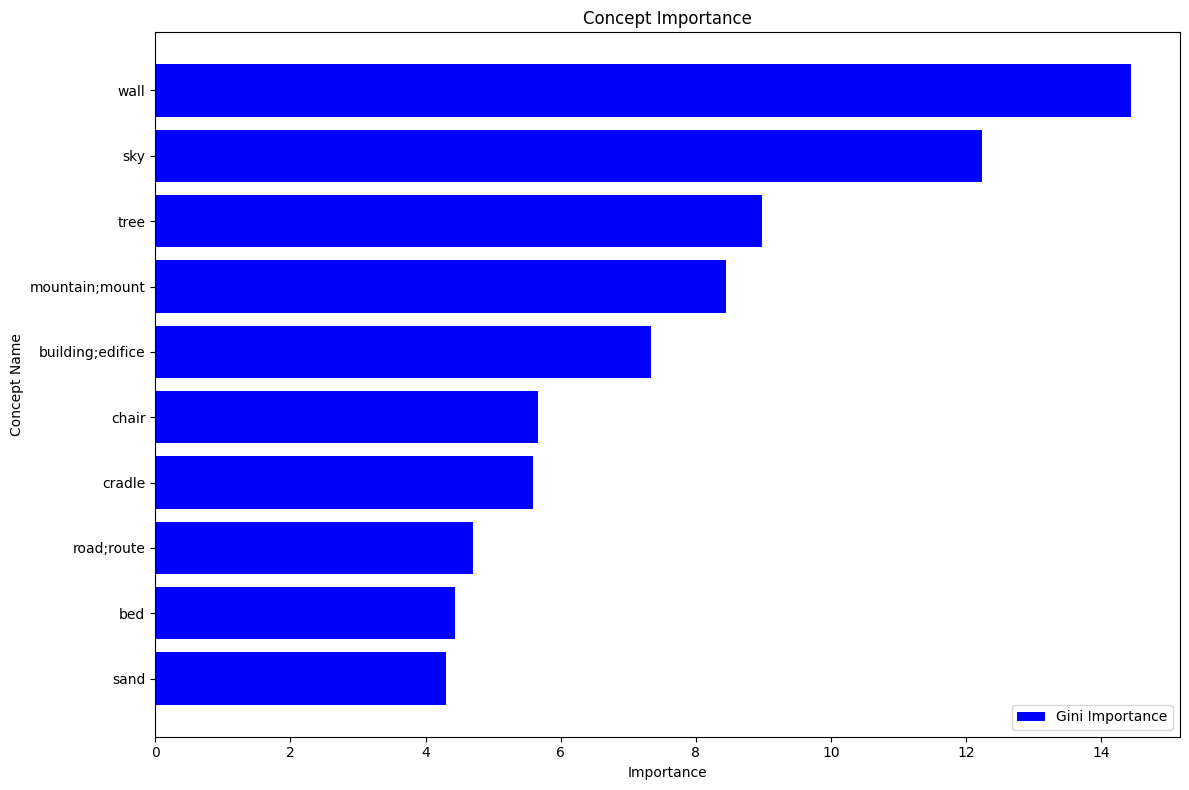

Image 4


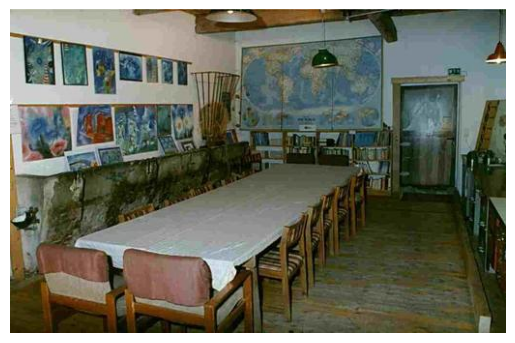

Correct label: restaurant

LIME explanation

Prediction: restaurant


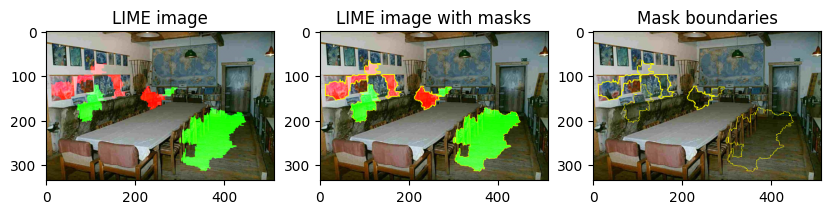


Concept explanation

True label for this image: restaurant
Predicted label for this image: desk


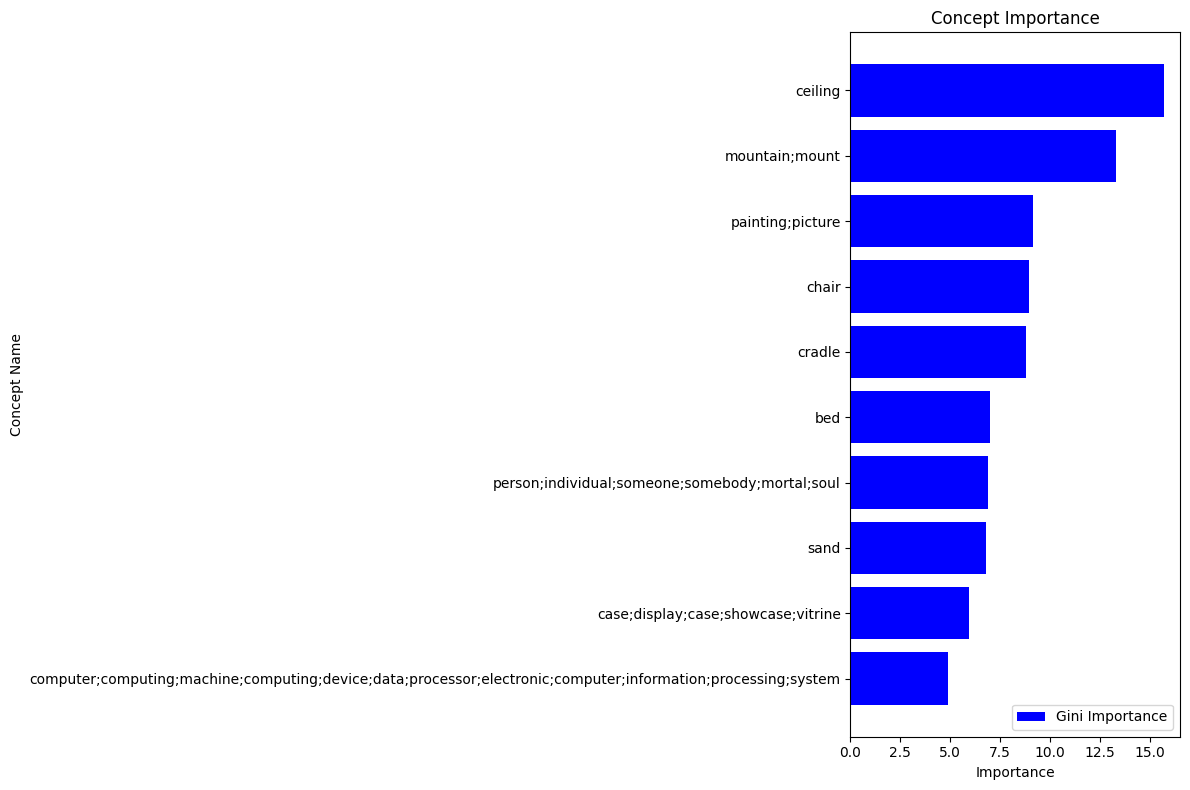

Image 5


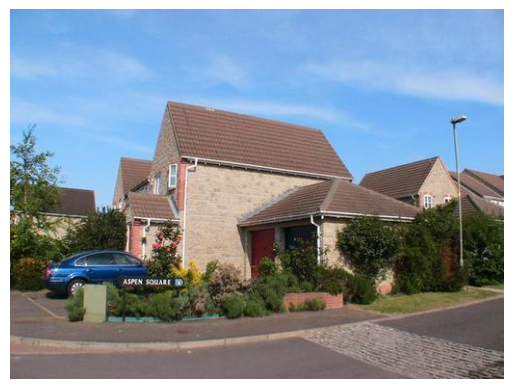

Correct label: tile_roof

LIME explanation

Prediction: cab


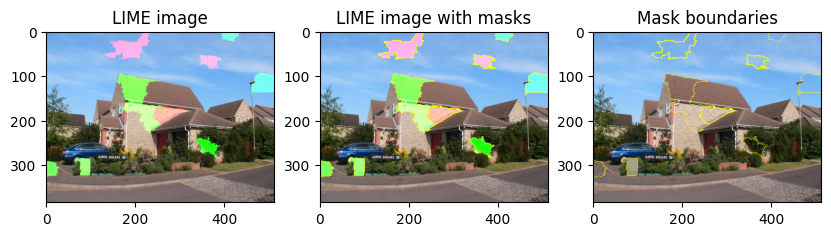


Concept explanation

True label for this image: tile_roof
Predicted label for this image: unicycle


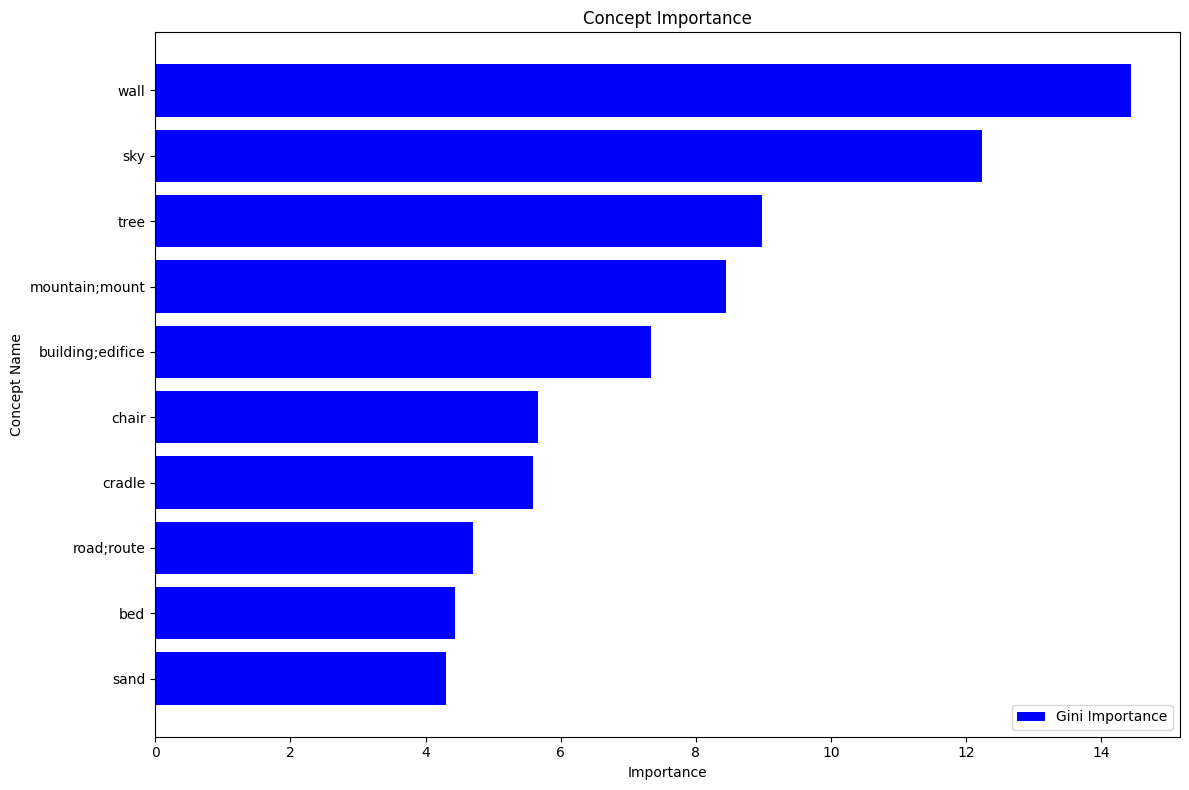

Image 6


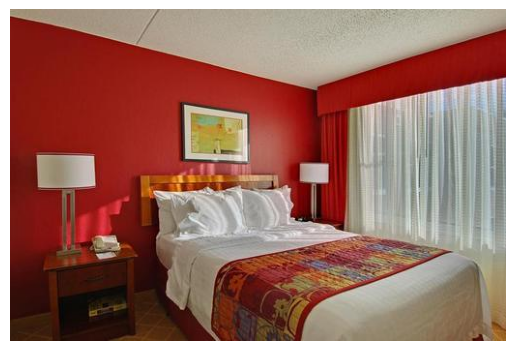

Correct label: quilt

LIME explanation

Prediction: quilt


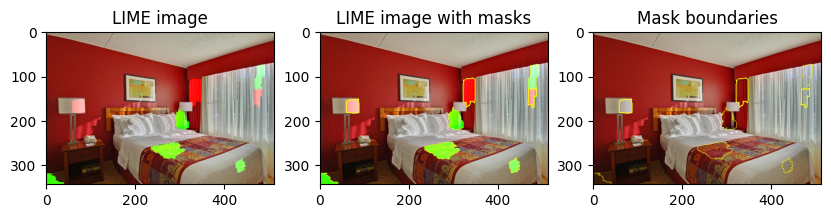


Concept explanation

True label for this image: quilt
Predicted label for this image: studio_couch


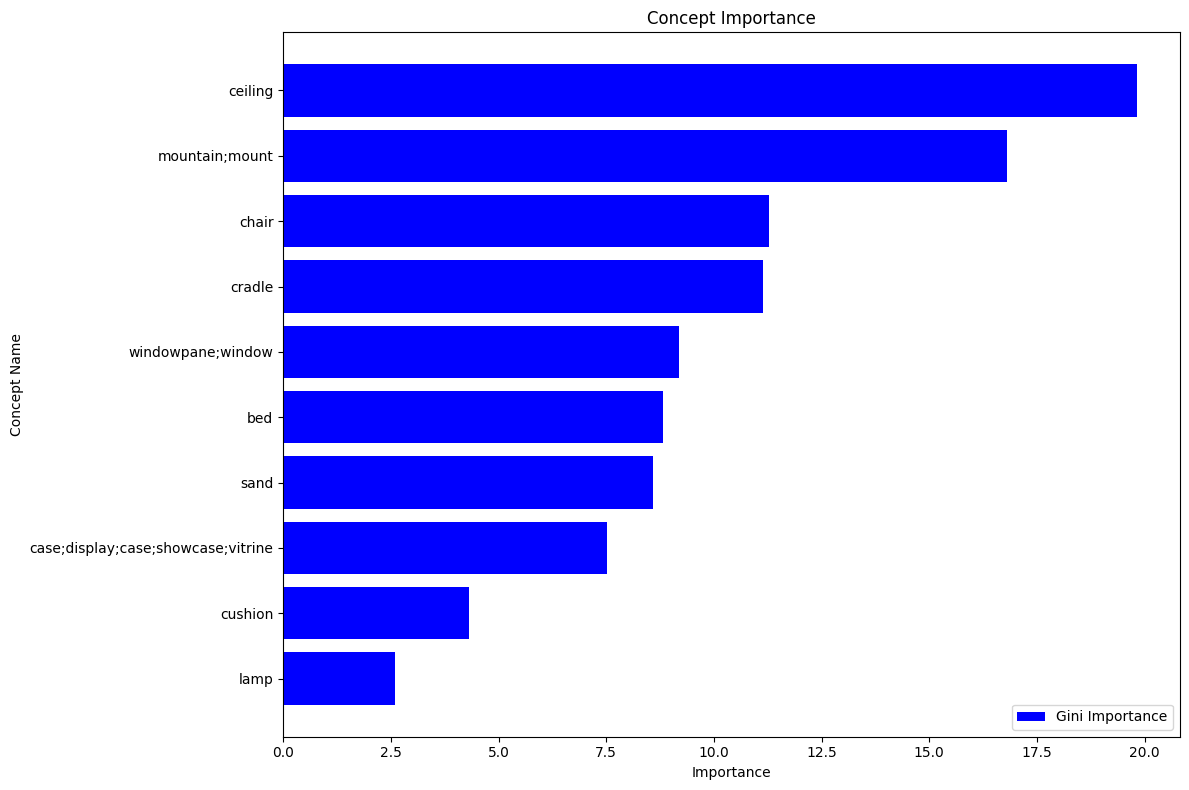

Image 7


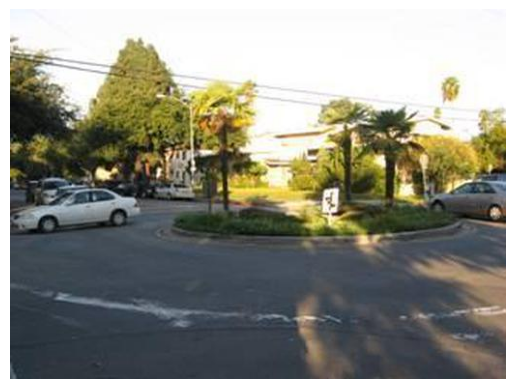

Correct label: motor_scooter

LIME explanation

Prediction: cab


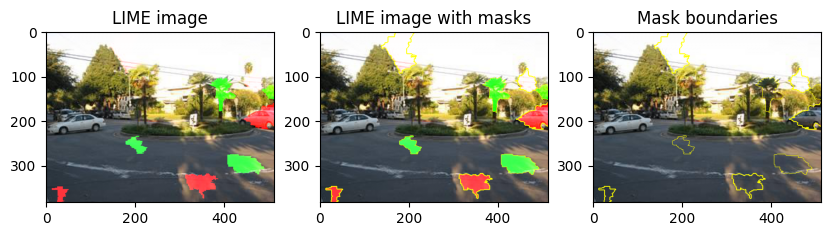


Concept explanation

True label for this image: motor_scooter
Predicted label for this image: bannister


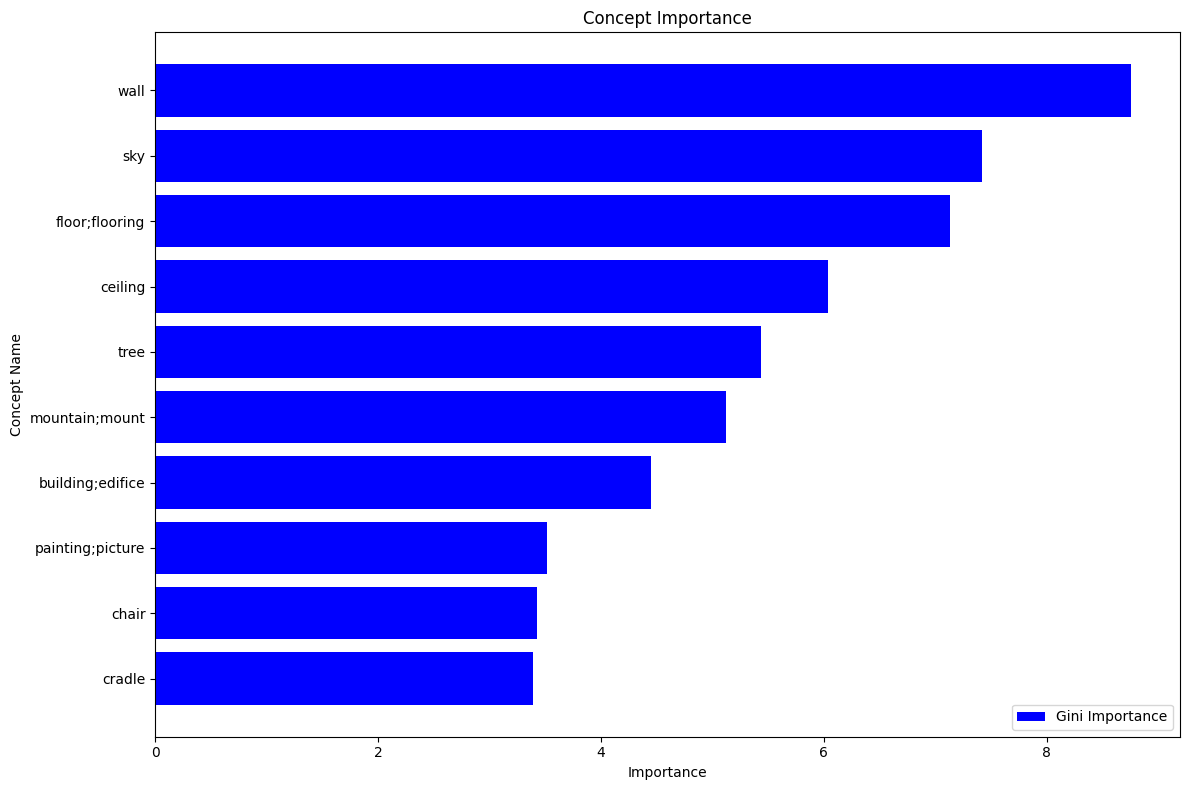

Image 8


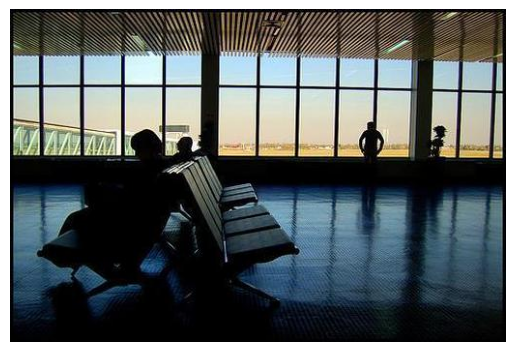

Correct label: accordion

LIME explanation

Prediction: grand_piano


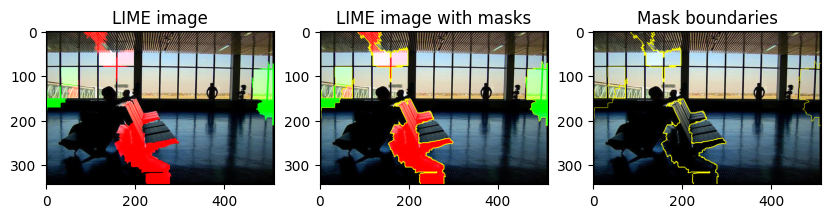


Concept explanation

True label for this image: accordion
Predicted label for this image: accordion


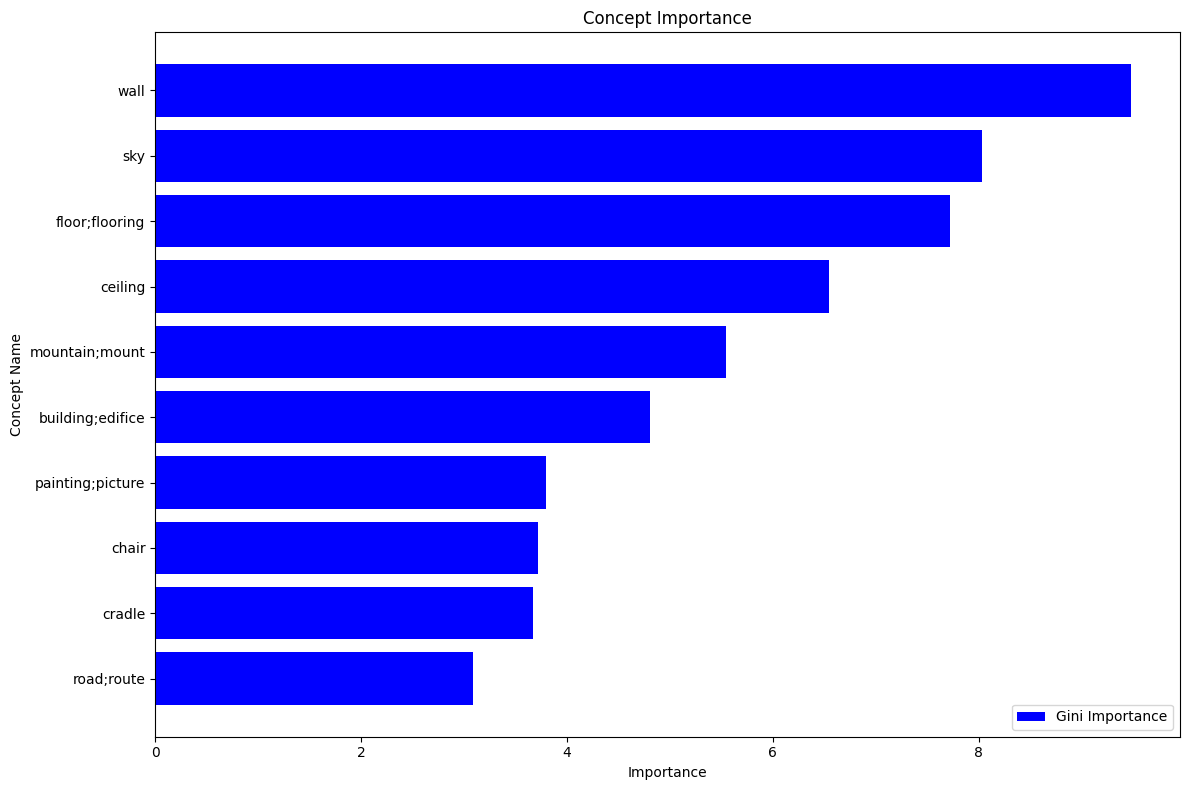

Image 9


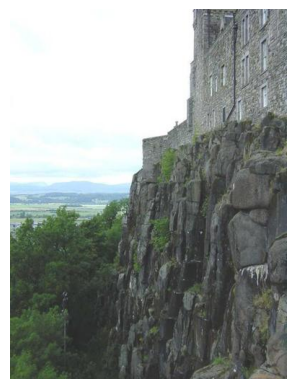

Correct label: cliff

LIME explanation

Prediction: cliff


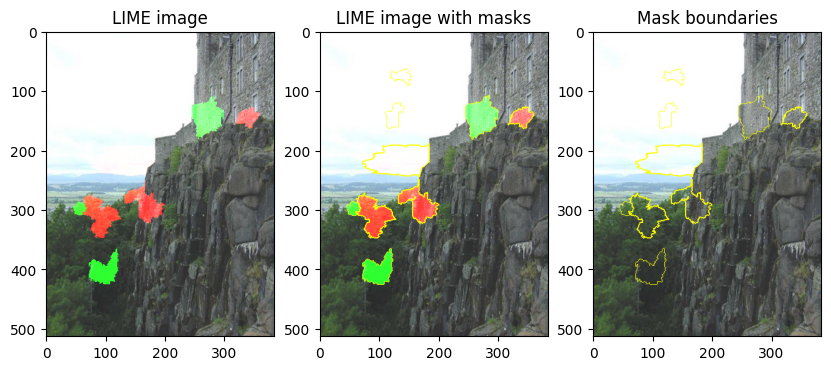


Concept explanation

True label for this image: cliff
Predicted label for this image: viaduct


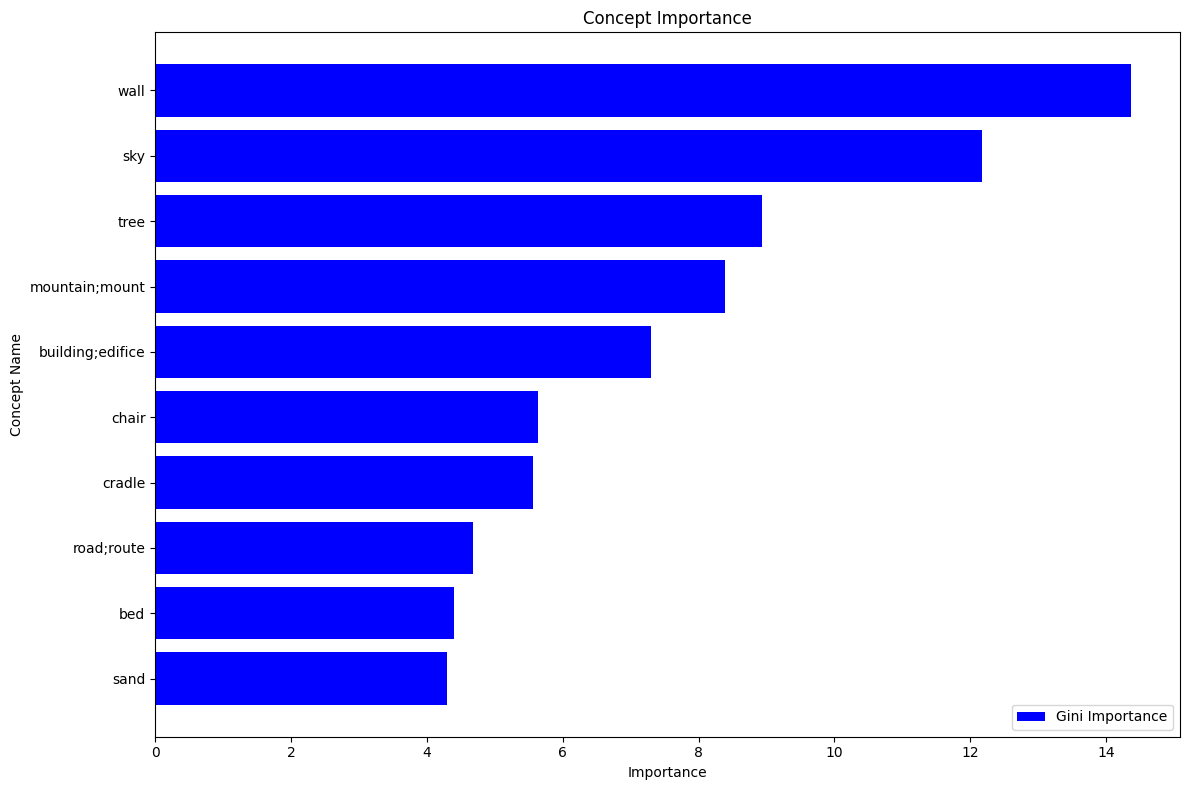

Image 10


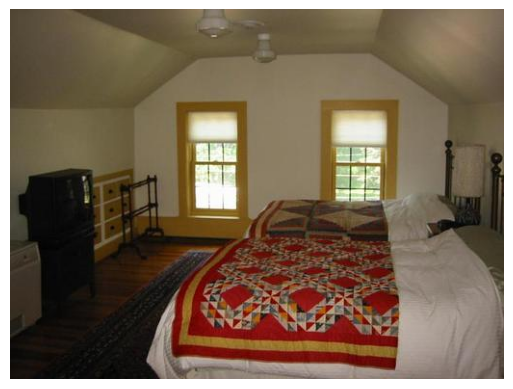

Correct label: quilt

LIME explanation

Prediction: studio_couch


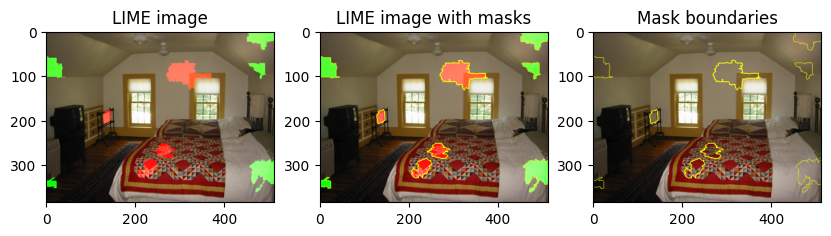


Concept explanation

True label for this image: quilt
Predicted label for this image: four-poster


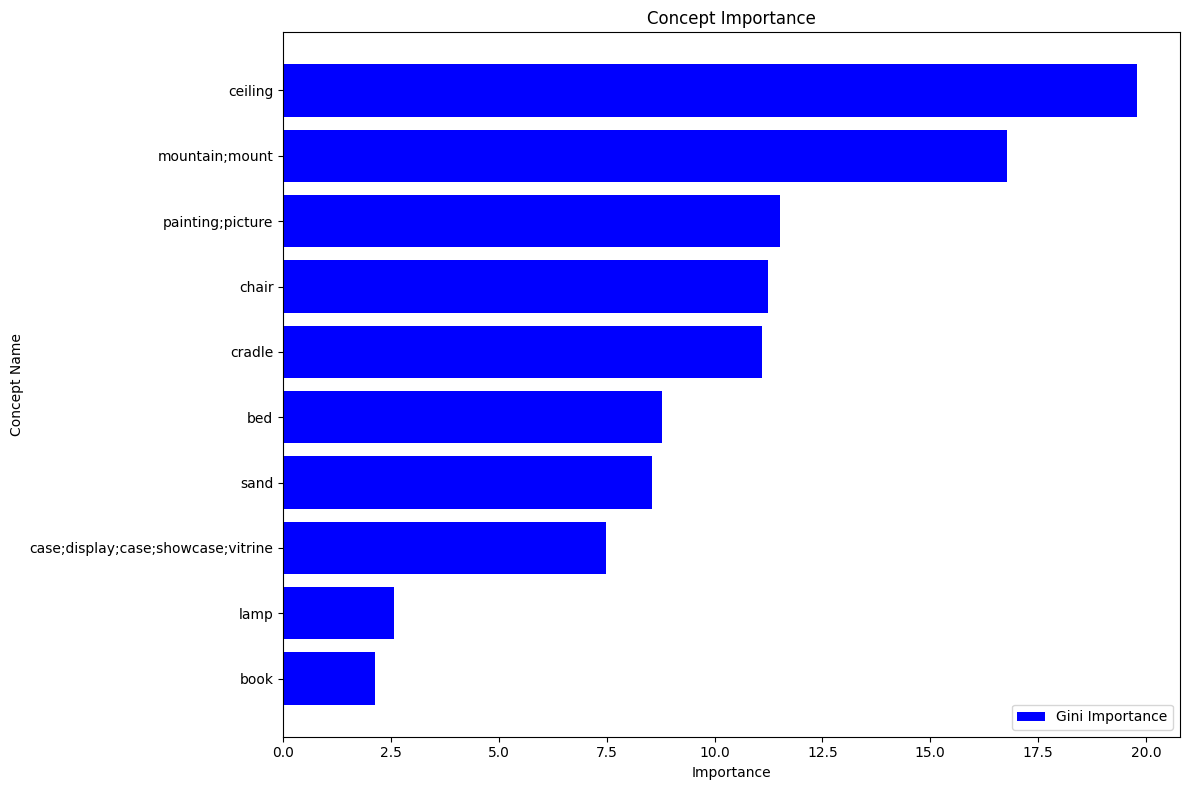

In [42]:
for i in range(10):
    print("Image "+str(i+1))
    vizualise_explanation(i)